In [1]:
import torch 
import torchvision.transforms as T 
from PIL import Image 
import matplotlib.pyplot as plt 

import sys 
import os 
sys.path.append("/home/jovyan/beomi/ayushraina/ddpm_pipeline") # Change this according to the path of your working directory
from diffusion import scheduler


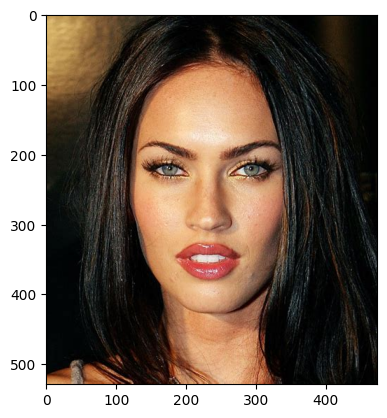

In [2]:
imagePath = "../data/LearningSet/learning1.png"
image = Image.open(imagePath).convert('RGB')

plt.imshow(image)
plt.show()

In [3]:
# Initializing the scheduler
Scheduler = scheduler.Diffusion_Scheduler()

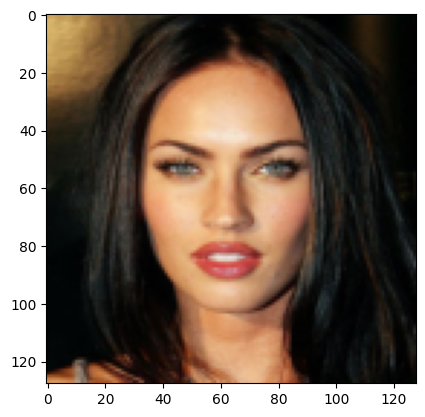

In [4]:
transform_pipeline = T.Compose([
    
    T.Resize((128, 128)),
    T.ToTensor()
    
])

newImage = transform_pipeline(image).unsqueeze(0)
plt.imshow(newImage.squeeze(0).permute(1,2,0))

plt.show()

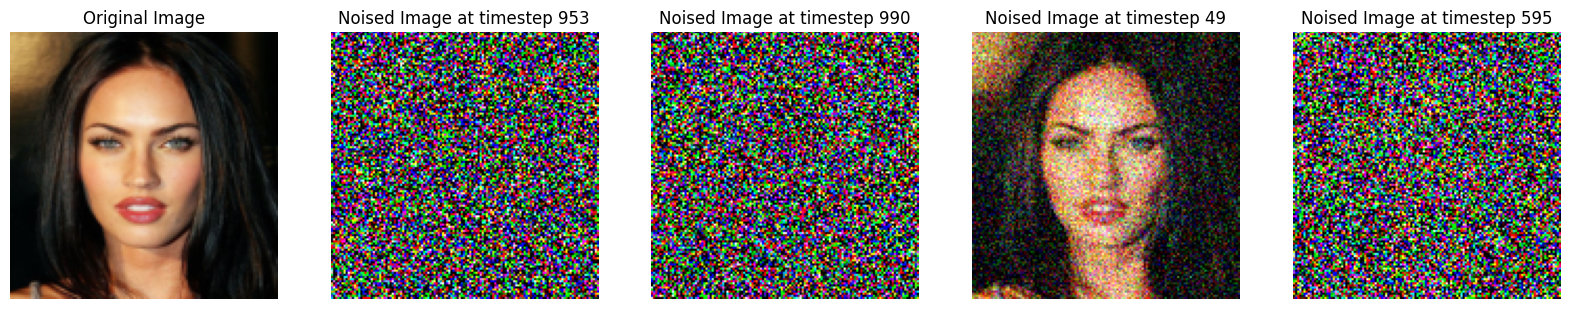

In [5]:
def showImages(originalImage):
    
    figure, axes = plt.subplots(1,5, figsize = (20,5))
    axes[0].imshow(originalImage.squeeze(0).permute(1,2,0))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    batch_size = originalImage.shape[0]
    for i in range(1,5):
        
        T = 1000
        timestep_t = torch.randint(0,1000,(batch_size,))
        
        x_t, noise = Scheduler.addNoiseKernel(originalImage,timestep_t)
        axes[i].imshow(x_t.squeeze(0).permute(1,2,0).clamp(0,1))
        axes[i].set_title(f"Noised Image at timestep {timestep_t.item()}")
        axes[i].axis("off")
        
    plt.show()
    
showImages(newImage)

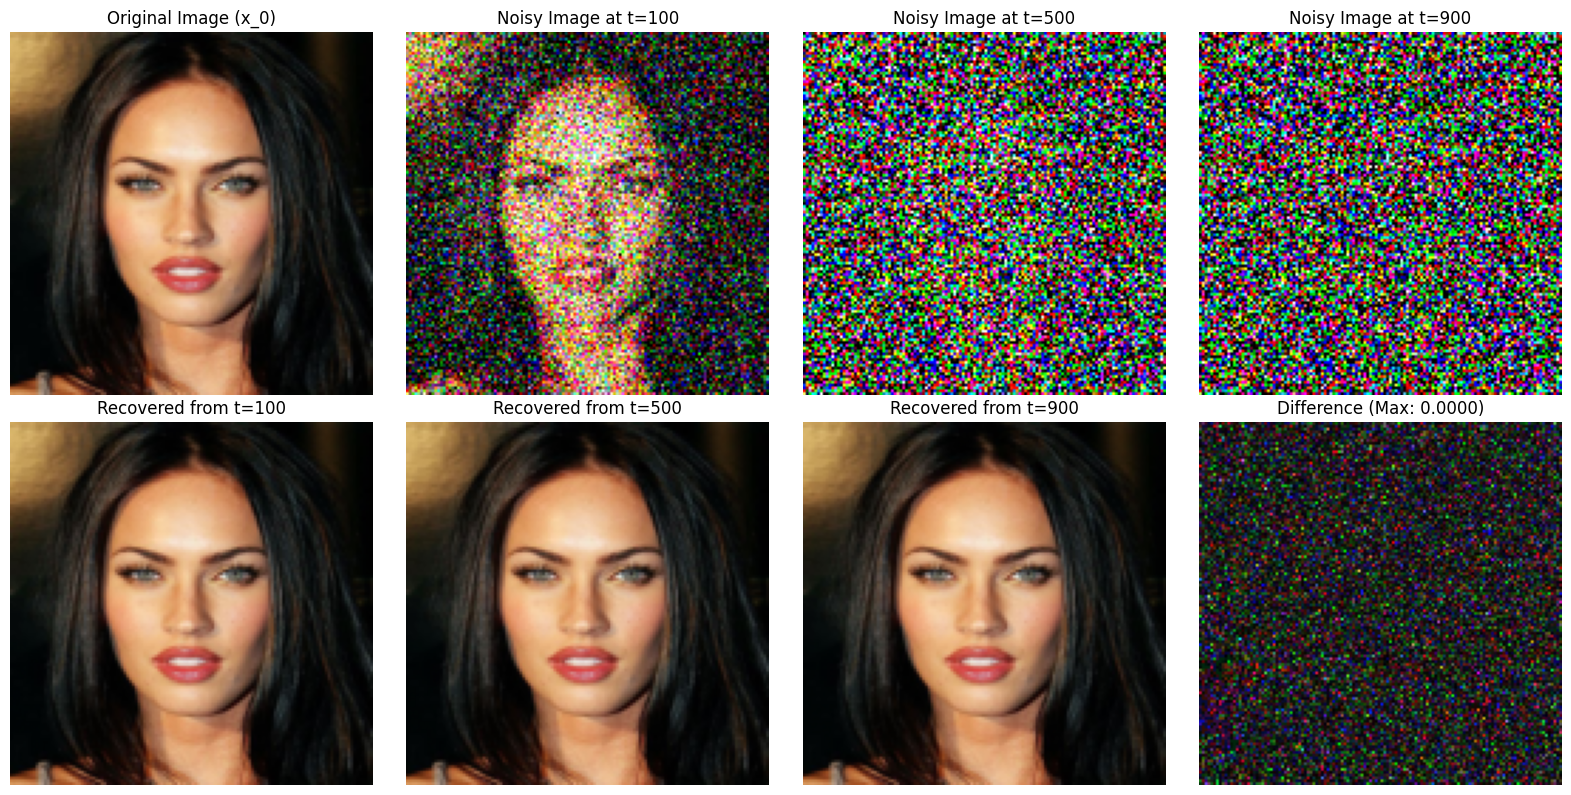

Mean Absolute Error: 0.000001
Max Error: 0.000008


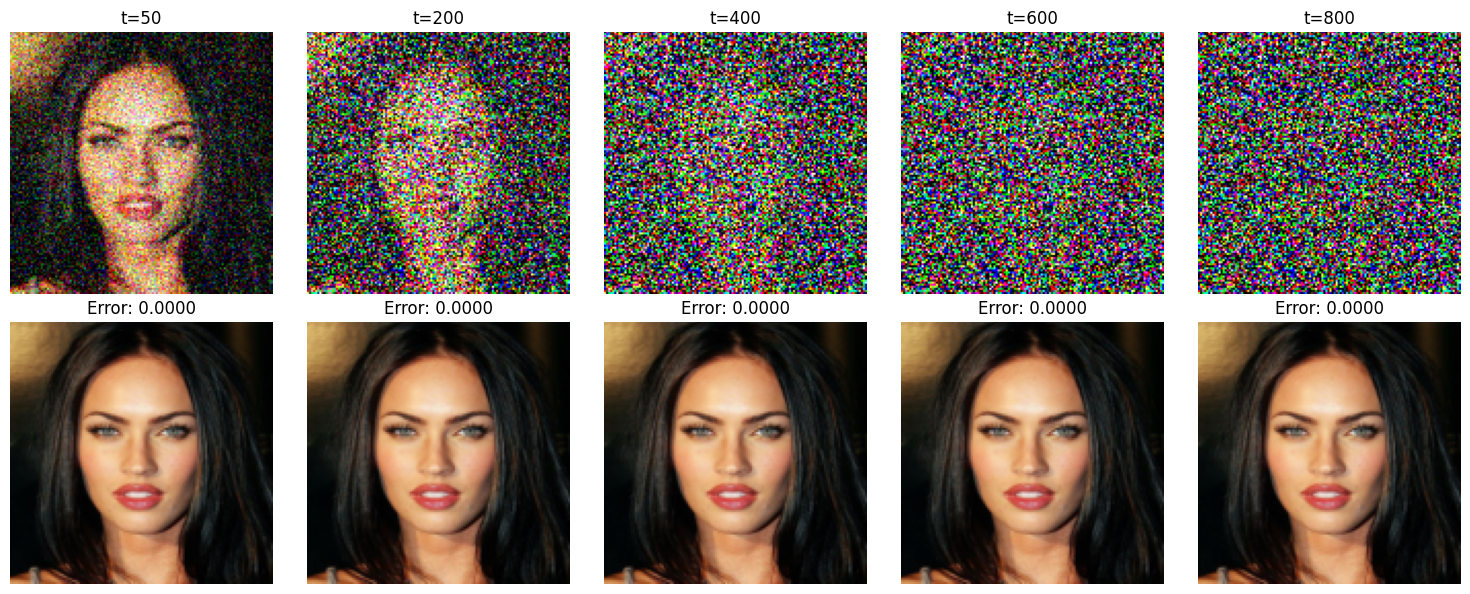

In [6]:
# Test for the predict_x0_from_noise function using a real image
# Check - I will be using original noise only, so reconstruction should be correct only.

import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.append("/home/jovyan/beomi/ayushraina/ddpm_pipeline")
from diffusion.scheduler import Diffusion_Scheduler

# Initialize the scheduler
Scheduler = Diffusion_Scheduler()

# Load and preprocess the image
imagePath = "../data/LearningSet/learning1.png"
image = Image.open(imagePath).convert('RGB')

transform_pipeline = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),  # Scales to [0, 1]
])

# Transform the image and add batch dimension
x_0 = transform_pipeline(image).unsqueeze(0)

# Function to display images with appropriate scaling
def display_image(tensor):
    # Make sure the tensor is properly scaled and in the right format
    img = tensor.squeeze(0).permute(1, 2, 0).clamp(0, 1).detach().cpu()
    return img

# Setup visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Display the original image
axes[0].imshow(display_image(x_0))
axes[0].set_title("Original Image (x_0)")
axes[0].axis('off')

# Test at different timesteps
timesteps = [100, 500, 900]

# Generate noise once to use for all timesteps (for consistent comparison)
noise = torch.randn_like(x_0)

for i, t in enumerate(timesteps):
    # Create tensor for the timestep
    t_tensor = torch.tensor([t])
    
    # Add noise to the image at this timestep
    x_t, _ = Scheduler.addNoiseKernel(x_0, t_tensor, noise=noise)
    
    # Display the noisy image
    axes[i+1].imshow(display_image(x_t))
    axes[i+1].set_title(f"Noisy Image at t={t}")
    axes[i+1].axis('off')
    
    # Try to recover the original image using the predict_x0_from_noise function
    # In a real scenario, we'd use a model to predict the noise
    # Here we use the actual noise we added (perfect prediction scenario)
    predicted_x_0 = Scheduler.predict_x0_from_noise(x_t, t_tensor, noise)
    
    # Display the recovered image
    axes[i+4].imshow(display_image(predicted_x_0))
    axes[i+4].set_title(f"Recovered from t={t}")
    axes[i+4].axis('off')

# Calculate and display the difference between original and recovered image
diff = torch.abs(x_0 - predicted_x_0)
max_diff = torch.max(diff).item()
mean_diff = torch.mean(diff).item()

# Scale difference image for better visibility
diff_scaled = diff / max_diff if max_diff > 0 else diff
axes[7].imshow(display_image(diff_scaled))
axes[7].set_title(f"Difference (Max: {max_diff:.4f})")
axes[7].axis('off')

plt.tight_layout()
plt.show()

# Print error metrics
print(f"Mean Absolute Error: {mean_diff:.6f}")
print(f"Max Error: {max_diff:.6f}")

# Optional: Test with gradually increasing noise levels
plt.figure(figsize=(15, 6))

# Select 5 increasing timesteps
test_timesteps = [50, 200, 400, 600, 800]

for i, t in enumerate(test_timesteps):
    t_tensor = torch.tensor([t])
    
    # Add noise
    x_t, _ = Scheduler.addNoiseKernel(x_0, t_tensor, noise=noise)
    
    # Try to recover
    predicted_x_0 = Scheduler.predict_x0_from_noise(x_t, t_tensor, noise)
    
    # Calculate error
    error = torch.mean(torch.abs(x_0 - predicted_x_0)).item()
    
    # Plot
    plt.subplot(2, 5, i+1)
    plt.imshow(display_image(x_t))
    plt.title(f"t={t}")
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(display_image(predicted_x_0))
    plt.title(f"Error: {error:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

[512, 256, 128, 64]
Simple U net initialized with: 
Input Channels: 3
Output Channels: 3
Base Channels: 64
Time Embedding Dimension: 128
Depth: 3
Channel Dimensions: [64, 128, 256, 512]


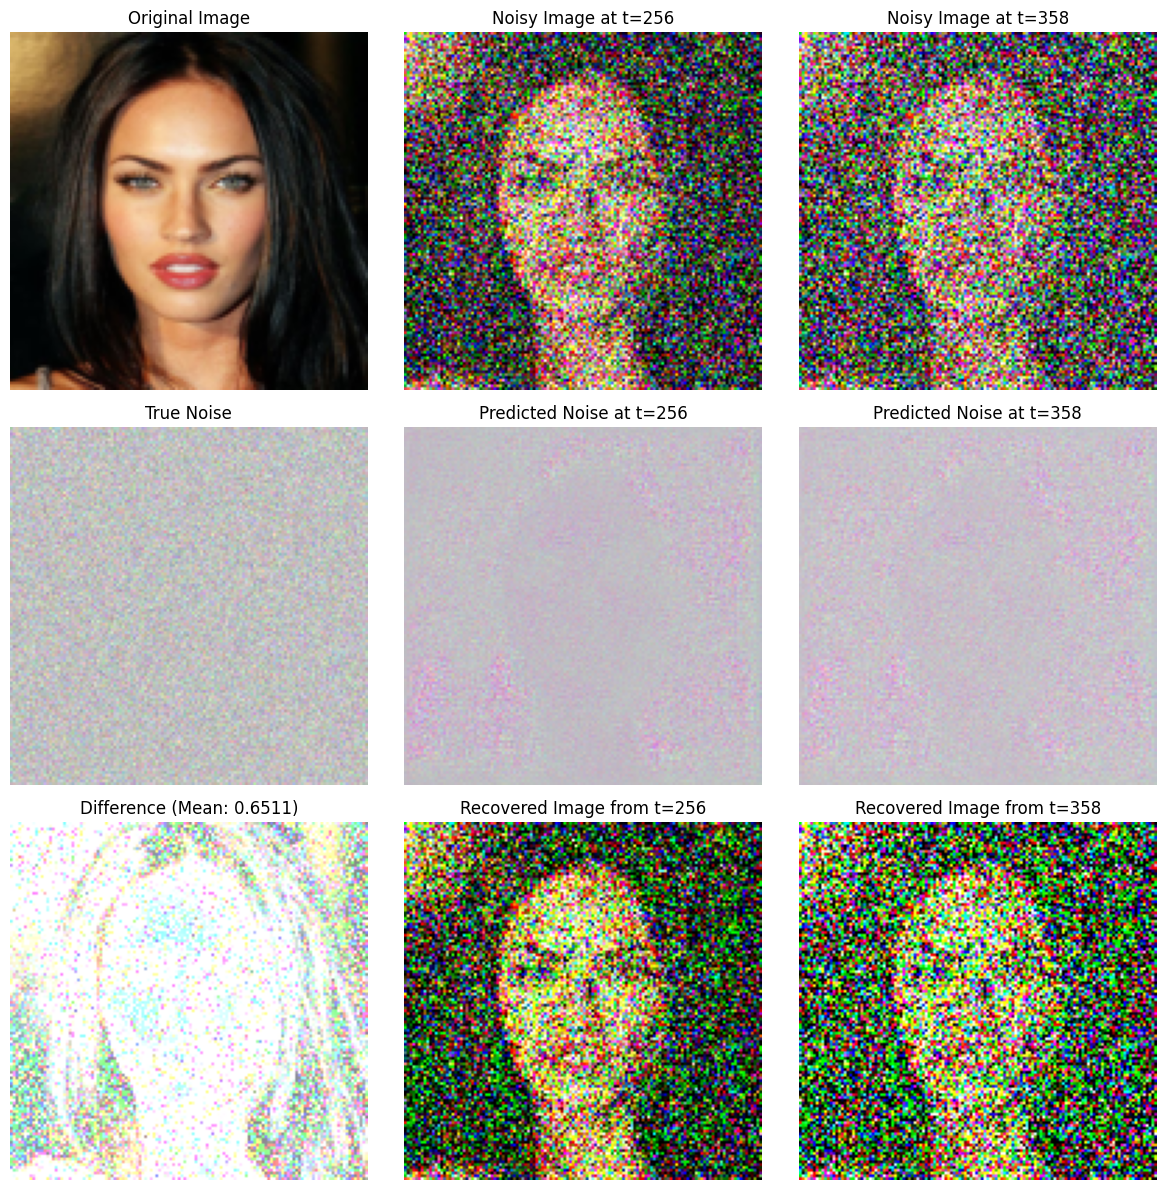

Timestep 256:
  Noise Prediction Error: 0.8390
  Image Reconstruction Error: 0.4918
Timestep 358:
  Noise Prediction Error: 0.8427
  Image Reconstruction Error: 0.6525


In [10]:
# Test UNet noise prediction and image reconstruction
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.append("/home/jovyan/beomi/ayushraina/ddpm_pipeline")
from diffusion.scheduler import Diffusion_Scheduler
from models.unet import SimpleUNetModel

# Set random seed for reproducibility
torch.manual_seed(42)

# Initialize the scheduler
scheduler = Diffusion_Scheduler()

# Initialize the UNet model
model = SimpleUNetModel(
    inChannels=3,       # RGB images
    outChannels=3,      # Output is noise prediction with same channels
    baseChannels=64,    # Starting number of channels
    timeEmbeddingDimension=128,
    depth=3,
    debug=False
)

# Load and preprocess the image
imagePath = "../data/LearningSet/learning1.png"
image = Image.open(imagePath).convert('RGB')

transform_pipeline = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),  # Scales to [0, 1]
    # Scale to [-1, 1] range which is better for diffusion models
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transform the image and add batch dimension
x_0 = transform_pipeline(image).unsqueeze(0)

# Function to display images with appropriate scaling
def display_image(tensor):
    # Convert [-1, 1] range back to [0, 1] for display
    img = tensor.squeeze(0).permute(1, 2, 0).detach().cpu()
    img = img * 0.5 + 0.5  # Denormalize
    img = torch.clamp(img, 0, 1)
    return img

# Test at different timesteps - using just 2 timesteps to fit in our grid
timesteps = torch.randint(0,1000,(2,))

# Setup visualization - 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Display the original image
axes[0, 0].imshow(display_image(x_0))
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# Generate noise once for visualization consistency
noise = torch.randn_like(x_0)

for i, t in enumerate(timesteps):
    # Create tensor for the timestep
    t_tensor = torch.tensor([t])
    
    # Add noise to the image at this timestep
    # Store the actual noise for comparison
    x_t, true_noise = scheduler.addNoiseKernel(x_0, t_tensor, noise=noise)
    
    # Display the noisy image
    axes[0, i+1].imshow(display_image(x_t))
    axes[0, i+1].set_title(f"Noisy Image at t={t}")
    axes[0, i+1].axis('off')
    
    # Use UNet to predict noise
    with torch.no_grad():  # No need for gradients in testing
        predicted_noise = model.forward(x_t, t_tensor)
    
    # Display the predicted noise (scaled for visibility)
    noise_display = (predicted_noise - predicted_noise.min()) / (predicted_noise.max() - predicted_noise.min())
    axes[1, i+1].imshow(display_image(noise_display))
    axes[1, i+1].set_title(f"Predicted Noise at t={t}")
    axes[1, i+1].axis('off')
    
    # Try to recover the original image using predicted noise
    predicted_x_0 = scheduler.predict_x0_from_noise(x_t, t_tensor, predicted_noise)
    
    # Display the recovered image
    axes[2, i+1].imshow(display_image(predicted_x_0))
    axes[2, i+1].set_title(f"Recovered Image from t={t}")
    axes[2, i+1].axis('off')

# Display true noise for comparison
true_noise_display = (true_noise - true_noise.min()) / (true_noise.max() - true_noise.min())
axes[1, 0].imshow(display_image(true_noise_display))
axes[1, 0].set_title("True Noise")
axes[1, 0].axis('off')

# Calculate and display difference between original and recovered
diff = torch.abs(x_0 - predicted_x_0)
axes[2, 0].imshow(display_image(diff * 5))  # Amplify difference for visibility
axes[2, 0].set_title(f"Difference (Mean: {torch.mean(diff):.4f})")
axes[2, 0].axis('off')

plt.tight_layout()
plt.show()

# Print error metrics
for t in timesteps:
    t_tensor = torch.tensor([t])
    x_t, true_noise = scheduler.addNoiseKernel(x_0, t_tensor)
    
    # Predict noise with UNet
    with torch.no_grad():
        predicted_noise = model(x_t, t_tensor)
    
    # Calculate noise prediction error
    noise_error = torch.mean(torch.abs(true_noise - predicted_noise)).item()
    
    # Recover image
    predicted_x_0 = scheduler.predict_x0_from_noise(x_t, t_tensor, predicted_noise)
    
    # Calculate image reconstruction error
    recon_error = torch.mean(torch.abs(x_0 - predicted_x_0)).item()
    
    print(f"Timestep {t}:")
    print(f"  Noise Prediction Error: {noise_error:.4f}")
    print(f"  Image Reconstruction Error: {recon_error:.4f}")